## Libraries installation and imports

In [1]:
# !pip install numpyro --quiet
# !pip install arch --quiet

In [2]:
import time
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import HTML

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model

from jax import vmap
import jax.numpy as jnp
import jax.random as random

import numpyro
from numpyro import handlers
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

In [3]:
%matplotlib inline

In [4]:
import warnings
warnings.filterwarnings('ignore')

## Methodology

In order to analyze relations between oil and oil products we identified prices of crude oil and related oil products for three separate locations. Data was collected using RESTful API requests to query the government agencies sources such as EIA and IMF. In Python it's done with help of **requests** library allowing us to make the API calls with specified search parameters(time period, frequency, etc).

In this study, we'll be focusing on the last five years, starting from October 2018 and going up to October 2023. We chose this time frame to assess how COVID-19, the Russia-Ukraine war, and Israel Hammas-Israel war affected petroleum prices. A five-year period provides a sufficiently large dataset for statistical analysis. This will allow us to perform the Exploratory Data Analysis(EDA) to draw meaningful conclusions about the relationships and correlations within the data. EDA is conducted using Python and popular data analysis libraries such as pandas, matplotlib, and seaborn.

First, we imported oil prices into a Pandas DataFrame for easier work with tabular data. Next step was to organize data by combining all prices in one dataframe, naming columns and setting proper datatime index to manipulate the time-series. Subsequently, the data was inspected for missing values to ensure data quality. As a part of EDA to visualize the cleaned data, libraries  **matplotlib** and **seaborn** were used to illustrate how oil prices changed over time. The dataset contains prices for crude oil and petroleum products, to describe the relationships between them we conducted a correlation analysis by finding correlation coefficients and building correlation matrix. In our project we've plotted a heatmap to demonstrate how each oil product price correlates with others.

For further statistical analysis we calculated the daily returns on the prices and plotted the returns and the distribution of returns. Using returns instead of prices will make our series stationary, meaning that mean and variance does not change over time.

In addition to EDA we conducted Quantile-Quantile (Q-Q) analysis using **scipy** library to assess whether returns follow a particular theoretical distribution.

In next section we performed ARIMA modeling on crude oil prices to help us understand and predict how oil prices might change over time. By analyzing past prices relationships in different regions and influenced by geopolitical events, the model tries to identify trends and patterns that may repeat in the future. Predicting future prices is crucial for managing risks. We utilized Time Series Analysis module of the **statsmodels** Python package. To ensure the data stationarity we used Augmented Dickey-Fuller Test. Next step to set up the ARIMA model is to identify the optimal model parameters by building the autocorrelation function (ACF) and partial autocorrelation function (PACF) plots. We will be using **statsmodels.graphics.tsaplots** library, specifically the plot_acf and plot_pacf functions.

ARIMA models allowed us to run only univariate time series modeling. Since we evaluate multiple variables in our dataset, multivariate techniques must be used to describe the relationships.

Therefore we applied Principal Component Analysis (PCA) to identify the patterns in the data. Machine learning library **scikit-learn** provides methods that we used to implement the PCA on the oil price data.


## Functions

In [5]:
grades = ['WTI', 'Urals', 'OPEC Basket']

# Visualize prices
def plot_prices(dfs):
  """Plot multiple line plots horizontally for crude oil and oil products prices from different regions"""
  # Create a figure and axis
  fig, axes = plt.subplots(1, len(dfs),figsize=(20, 4), sharey=True)

  for df, grade, ax in zip(dfs, grades, axes):
    # Plot the WTI Crude Oil prices dollars per barrel on the left axis
    ax.set_xlabel('Date')
    ax.set_ylabel(grade + ' Crude $/bbl')

    ax.plot(df.index, df['Crude'], color='k', label=(grade + ' Crude'))

    # Plot the oil products prices on the right axis

    ax2 = ax.twinx()
    ax2.set_ylabel('Oil Prodicts, $/gal')
    for column in df.columns[1:6]:
      ax2.plot(df.index, df[column], label=column)

    # Adjust the legend and show the plot

  # fig.legend(loc='upper center', ncol=len(dfs[0].columns))
  plt.tight_layout()
  plt.show()

# Output the dataset
def output_horizontally(dfs, func):
   html = '<div style="display:flex">'
   for df, grade in zip(dfs, grades):
       html += '<div>'
       html += '<div style="display:flex; justify-content:center">'+grade+'</div>'
       html += '<div style="margin-right: 32px">'
       html += func(df).to_html()
       html += '</div></div>'
   html += '</div>'
   display(HTML(html))


def print_prices(dfs):
    """Display prices"""
    output_horizontally(dfs, func=pd.DataFrame.head)


def get_stats(dfs):
   """Function for basic statistics"""
   output_horizontally(dfs, func=pd.DataFrame.describe)

def check_na(dfs):
   """Check for missing values"""
   output_horizontally(dfs, func=lambda df: df[df.isnull().any(axis=1)])

def fill_na(dfs):
   """Fill missing (NaN) values in a DataFrame with the last observation value"""
   for df in dfs:
    df.fillna(method='ffill', inplace=True)
   output_horizontally(dfs, func=lambda df: df[df.isnull().any(axis=1)])

def calc_returns(dfs):
  """Estimating simple returns"""
  returns_dfs = []
  html = '<div style="display:flex">'
  for df, grade in zip(dfs, grades):
    df = df.pct_change().dropna()
    html += '<div>'
    html += '<div style="display:flex; justify-content:center">'+grade+'</div>'
    html += '<div style="margin-right: 32px">'
    html += df.head().to_html()
    html += '</div></div>'
    returns_dfs.append(df)
  html += '</div>'
  display(HTML(html))

  return returns_dfs

def plot_corr_matrix(dfs):
  """Plot correlation matrices for oil/oil products dataframes"""

  num_plots = len(dfs)

  sns.set_theme(style="white")

  fig, axes = plt.subplots(1, num_plots, figsize=(6 * num_plots, 5), sharey=True, gridspec_kw={'wspace': 0.5})

  for i, df in enumerate(dfs):
    # Calculate the correlation matrix
    corr_matrix = df.corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    # Plot the correlation matrix using Seaborn heatmap
    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, ax=axes[i])
    axes[i].set_title('Correlation Matrix - ' + grades[i] + ' Crude Oil/Oil Products Relationship')

  # Show the plot
  plt.show()

def box_plots(dfs):
    """Plot oil prices returns box plots on for each region"""

    num_plots = len(dfs)

    fig, axes = plt.subplots(nrows=1, ncols=num_plots, figsize=(15, 4))

    for i, (df, grade) in enumerate(zip(dfs, grades)):
        sns.boxplot(data=df, ax=axes[i])
        axes[i].set_title(f'Box Plot - {grade}')

    plt.tight_layout()
    plt.show()

def trim_outliers(dfs):
  """Trim outliers of oil price returns using the percentile method"""

  trimmed_dfs=[]

  for df in dfs:
    # Calculate the 0.99 and 0.01 quantiles
    upper_limit = df['Crude'].quantile(0.99)
    lower_limit  = df['Crude'].quantile(0.01)
    # Filter the DataFrame to keep values within the upper and lower limits
    df  = df[(df['Crude'] < upper_limit) & (df['Crude'] > lower_limit)]
    trimmed_dfs.append(df)

  return trimmed_dfs

def adf_test(dfs):
  """Test oil price returns data for stationarity"""

  html = '<div>'
  for df, grade in zip(dfs, grades):
    adf_df = pd.DataFrame(index=['ADF Statistic','p-value'])
    for product in df:
       adf_result = adfuller(df[product])
       adf_df[product] = [adf_result[0], adf_result[1]]
    html += '<div>'
    html += '<div style="margin-left: 300px">'+grade+'</div>'
    html += '<div style="margin-bottom: 16px">'
    html += adf_df.to_html()
    html += '</div></div>'
  html += '</div>'
  display(HTML(html))

def ac_plot(dfs):
  """Plot autocorrelation functions"""

  fig, axes = plt.subplots(1, 3, figsize=(12, 3))

  for i, (df, grade) in enumerate(zip(dfs, grades)):
    # Plot ACF plot
    plot_acf(df['Crude'], lags=10,  title=f'ACF Plot - {grade}', ax=axes[i])
    axes[i].set_title(f'ACF Plot - {grade}')

  plt.tight_layout()
  plt.show()

  fig, axes = plt.subplots(1, 3, figsize=(12, 3))

  for i, (df, grade) in enumerate(zip(dfs, grades)):
    # Plot PACF plot

    plot_pacf(df['Crude'], lags=10,  method='ols', title=f'PACF Plot - {grade}', ax=axes[i])
    axes[i].set_title(f'PACF Plot - {grade}')

  plt.tight_layout()
  plt.show()

def statistics(dfs):
  """Calculate key statistic metrics"""

  html = '<div style="display:flex">'
  for df, grade in zip(dfs, grades):
    stats_df = pd.DataFrame(index=['Mean','Median','Variance','Skewness','Kurtosis'])
    # Populating the dataframe with metrics
    for product in df:
      stats_df[product] = [df[product].mean(), df[product].median(),df[product].var(), stats.skew(df[product], axis=0, bias=True), stats.kurtosis(df[product], axis=0, bias=True)]
    html += '<div>'
    html += '<div style="display:flex; justify-content:center">'+grade+'</div>'
    html += '<div style="margin-right: 32px">'
    html += stats_df.to_html()
    html += '</div></div>'
  html += '</div>'
  display(HTML(html))

def qqplot(dfs):
  """Q-Q Plots"""

  fig, axes = plt.subplots(1, 3, figsize=(12, 3))

  for i, (df, grade) in enumerate(zip(dfs, grades)):
    # Plot Q-Q plot
    sm.qqplot(df['Crude'], ax=axes[i])
    axes[i].set_title(f'Q-Q Plot - {grade}')

  plt.tight_layout()
  plt.show()

def calc_covariance(dfs):
  output_horizontally(dfs, func=pd.DataFrame.cov)


def split_data(dfs):
  """Splitting data into training, testing, and validation sets"""
  split_dfs = []

  for df in dfs:
    train = df[: int(df.shape[0] * 0.80)]
    validation = df[int(0.80 * df.shape[0]) : int(0.90 * df.shape[0])]
    test = df[int(0.90* df.shape[0]) : int(df.shape[0])]
    split_dfs.append((train, validation, test))

  return split_dfs

def summarize_arima(dfs):
  html = '<div style="display:flex">'

  for df, grade in zip(dfs, grades):
    model = ARIMA(df['Crude'], order=(1,0,1))
    model_fit = model.fit()
    summary = model_fit.summary()

    html += '<div>'
    html += '<div style="display:flex; justify-content:center">'+grade+'</div>'

    for table in summary.tables:
      table_data = table.data
      # Create a DataFrame
      results_df = pd.DataFrame(table_data[1:], columns=table_data[0])
      html += '<div style="margin-right: 32px; margin-bottom: 16px">'
      html += results_df.to_html(index=False)
      html += '</div>'
    html += '</div>'
  html += '</div>'
  display(HTML(html))

def perform_pca(dfs):
  num_plots = len(dfs)
  fig, axes = plt.subplots(nrows=1, ncols=num_plots, figsize=(20, 4))

  for i, (df, grade) in enumerate(zip(dfs, grades)):
    # Standardize the Data
    scaler = StandardScaler()
    data_standardized = scaler.fit_transform(df)

    # Apply PCA
    pca = PCA()
    principal_components = pca.fit_transform(data_standardized)

    # Explained Variance
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_explained_variance = np.cumsum(explained_variance_ratio)

     # Plot the results
    axes[i].plot(range(1, len(explained_variance_ratio) + 1), cumulative_explained_variance, marker='o')
    axes[i].set_title(grade + ' Cumulative Explained Variance')
    axes[i].set_xlabel('Number of Principal Components')
    axes[i].set_ylabel('Cumulative Explained Variance')
    axes[i].legend()

  plt.show()

## Data sources and data retrieval
In our research, we'll be using multiple sources of oil prices data for each of three regions that are discussed in the paper: United States, Russia and Middle East.
Data for US crude oil benchmark West Texas Intermediate (WTI) is coming from two main sources provided by the U.S. government. The first one is the Energy Information Administration (EIA), which gives us information about the crude oil prices, including prices for derived oil products such as gasoline, jet fuel, diesel, heating oil and propane. The second source is the Federal Reserve Economic Data, St. Louis (FRED), maintained by the Federal Reserve Bank of St. Louis. FRED provides economic time-series data.
The time-series is obtained through open data tools and Application Programming Interface (API).

Middle East region is represented by Dubai crude which is commonly used as benchmark for the pricing of Middle Eastern oil, consisting of Dubai, Oman or Abu Dhabi oil.

Russian oil is represented by Urals blend. Data is obtained from Saint Petersburg International Mercantile Exchange https://spimex.com/en/

In [6]:
# EIA API connection details
api_key = "WyIzc4qhpYE6rxEDvB216tCCuvSkHBwGLJ6ddpam"
eia_url = 'https://api.eia.gov/v2/petroleum/pri/spt/data/'

# List of oil products and codes
products = [
  {'name': 'Crude', 'code':'RWTC'},
  {'name': 'Gasoline', 'code':'EER_EPMRU_PF4_Y35NY_DPG'},
  {'name': 'Jet Fuel', 'code':'EER_EPJK_PF4_RGC_DPG'},
  {'name': 'Diesel', 'code':'EER_EPD2DXL0_PF4_Y35NY_DPG'},
  {'name': 'Heating Oil', 'code':'EER_EPD2F_PF4_Y35NY_DPG'},
  {'name': 'Propane', 'code':'EER_EPLLPA_PF4_Y44MB_DPG'}
  ]

start_date = '2019-01-01'
end_date = '2023-11-01'
date_range = pd.date_range(start_date, end_date, freq='D').strftime('%Y-%m-%d')

wti_df = pd.DataFrame(date_range, columns=['Date'])

for product in products:
  # Query parameters
  params = '?frequency=daily&data[0]=value&facets[series][]=%s&start=%s&end=%s&sort[0][column]=period&sort[0][direction]=asc&api_key=%s' % (product['code'], start_date, end_date, api_key)

  # Fetch the data using GET request
  data = requests.get(eia_url + params).json()
  df = pd.DataFrame(data['response']['data'])

  # Naming column with oil product name
  df.rename(columns={"value": product['name'], "period": 'Date'}, inplace=True)

  # Merging price series
  wti_df = pd.merge(wti_df, df[['Date', product['name']]], on='Date')

# Setting proper index
wti_df['Date'] = pd.to_datetime(df['Date'])
wti_df.set_index('Date', inplace=True)

In [7]:
opec_df = pd.read_csv('https://raw.githubusercontent.com/timdanilov/capstone-project/main/data/oil_products_prices_opec.csv', sep=',', index_col='Date', parse_dates=True)

In [8]:
urals_df = pd.read_csv('https://raw.githubusercontent.com/timdanilov/capstone-project/main/data/oil_products_prices_russia.csv', sep=',', index_col='Date', parse_dates=True)

## Data preproccessing

In [9]:
# Check for missing values and show rows with missing values
check_na([wti_df, urals_df, opec_df])

,Crude,Gasoline,Jet Fuel,Diesel,Heating Oil,Propane
Date,,,,,,
,Crude,Gasoline,Jet Fuel,Diesel,Heating Oil,Propane
Date,,,,,,
2022-08-12,74.52,2.612,2.808,NaN,2.908,0.688
2023-01-03,56.51,NaN,2.280,2.32,2.276,0.528
2023-04-13,67.31,2.476,2.564,2.62,2.584,NaN
2023-08-30,69.88,2.272,2.840,NaN,2.876,1.032
,Crude,Gasoline,Jet Fuel,Diesel,Heating Oil,Propane
Date,,,,,,


The Urals dataset contains some missing values that will be replaced with previous values

In [10]:
fill_na([wti_df, urals_df, opec_df])

,Crude,Gasoline,Jet Fuel,Diesel,Heating Oil,Propane
Date,,,,,,
,Crude,Gasoline,Jet Fuel,Diesel,Heating Oil,Propane
Date,,,,,,
,Crude,Gasoline,Jet Fuel,Diesel,Heating Oil,Propane
Date,,,,,,


In [11]:
print_prices([wti_df, urals_df, opec_df])

,Crude,Gasoline,Jet Fuel,Diesel,Heating Oil,Propane
Date,,,,,,
2019-01-02,46.31,1.394,1.607,1.705,1.687,0.641
2019-01-03,46.92,1.405,1.658,1.738,1.716,0.630
2019-01-04,47.76,1.408,1.711,1.778,1.753,0.635
2019-01-07,48.27,1.395,1.714,1.803,1.754,0.623
2019-01-08,49.58,1.413,1.758,1.822,1.790,0.628
,Crude,Gasoline,Jet Fuel,Diesel,Heating Oil,Propane
Date,,,,,,
2019-01-02,54.11,2.124,2.348,2.488,2.396,0.524
2019-01-03,53.88,2.156,2.316,2.448,2.356,0.524


Data in the datasets is clean and ready for Exploratory Data Analysis.

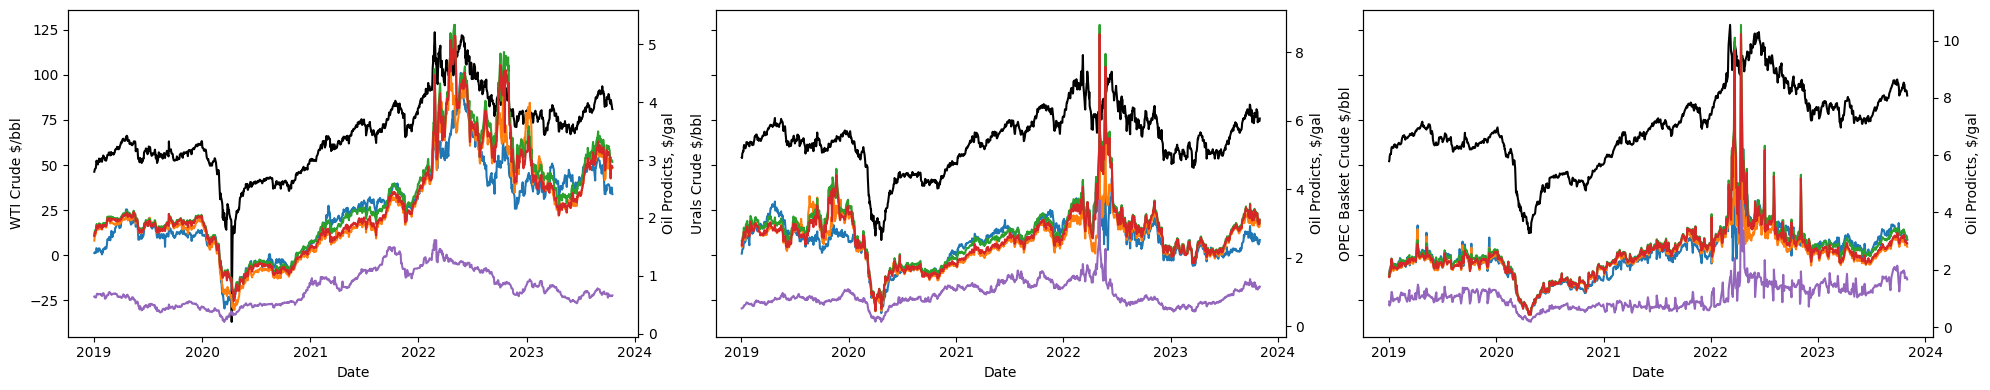

In [12]:
plot_prices([wti_df, urals_df, opec_df])

Oil and oil products prices plots for each region. Left axis - Crude oil price in US Dollars per barrel - black line. Right axis - Oil products price in USD per Gallon - colored lines. On the plots we observed crude oil price curves were similar for every region, at the same time oil products prices had different shapes and dynamics.

## Exploratory Data Analysis

In [13]:
# Basic statistics of the dataset
get_stats([wti_df, urals_df, opec_df])

,Crude,Gasoline,Jet Fuel,Diesel,Heating Oil,Propane
count,1217.000000,1217.000000,1217.000000,1217.000000,1217.000000,1217.000000
mean,66.989836,2.135974,2.163524,2.340898,2.234086,0.776353
std,21.150673,0.741859,0.868073,0.934106,0.895692,0.306704
min,-36.980000,0.434000,0.407000,0.602000,0.562000,0.203000
25%,53.600000,1.650000,1.696000,1.815000,1.741000,0.513000
50%,66.080000,2.122000,1.931000,2.073000,1.979000,0.703000
75%,80.700000,2.623000,2.780000,2.907000,2.740000,1.014000
max,123.640000,4.509000,5.066000,5.339000,5.152000,1.615000
,Crude,Gasoline,Jet Fuel,Diesel,Heating Oil,Propane
count,1215.000000,1215.000000,1215.000000,1215.000000,1215.000000,1215.000000


We calculated and analyzed basic statistics for all three datasets. WTI Crude prices have the widest range from a minimum of -36.98 in 2020 when oil prices went negative due to oversupply to a maximum of 123.64 in 2022. Urals ranges from 8.4 to 111 USD and OPEC basket from 12.2 to 127.74. OPEC basket prices have the highest standard deviation of 21.96 compared to 21.16 and 15.9 for WTI and Urals respectively. This might tell us that OPEC basket prices a more volatile. Despite wide swings and negative prices WTI has lower sigma.

### Calculating returns

In [14]:
# Calculate returns
wti_returns_df, urals_returns_df, opec_returns_df = calc_returns([wti_df, urals_df, opec_df])

,Crude,Gasoline,Jet Fuel,Diesel,Heating Oil,Propane
Date,,,,,,
2019-01-03,0.013172,0.007891,0.031736,0.019355,0.017190,-0.017161
2019-01-04,0.017903,0.002135,0.031966,0.023015,0.021562,0.007937
2019-01-07,0.010678,-0.009233,0.001753,0.014061,0.000570,-0.018898
2019-01-08,0.027139,0.012903,0.025671,0.010538,0.020525,0.008026
2019-01-09,0.052642,0.046001,0.036974,0.030735,0.031285,0.047771
,Crude,Gasoline,Jet Fuel,Diesel,Heating Oil,Propane
Date,,,,,,
2019-01-03,-0.004251,0.015066,-0.013629,-0.016077,-0.016694,0.000000
2019-01-04,0.044729,0.044527,0.046632,0.050654,0.050934,0.015267


### Plotting blox plot to identify the outliers

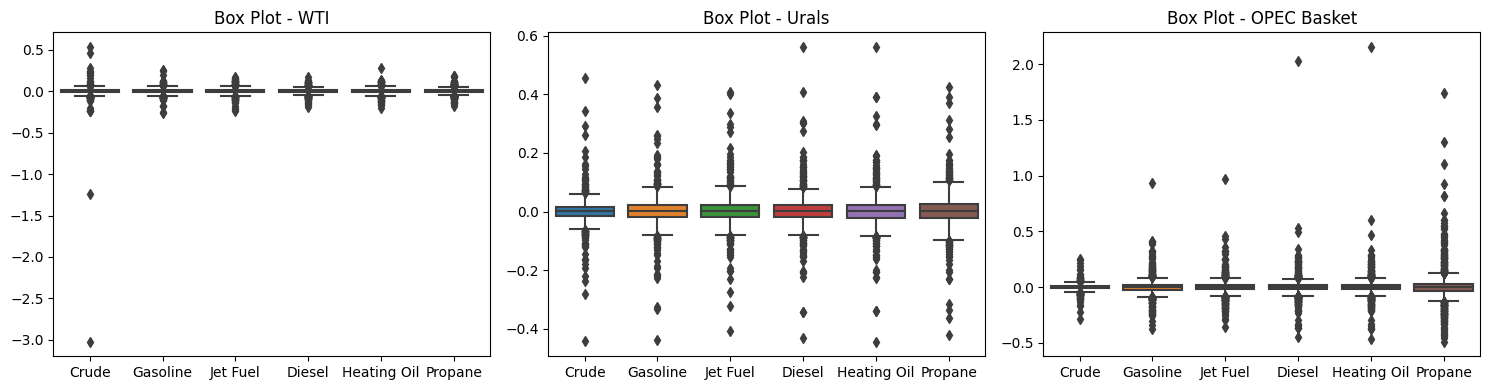

In [15]:
box_plots([wti_returns_df, urals_returns_df, opec_returns_df])

In our analysis of oil price returns, we employed a box plot to visually assess the distribution of returns. A box plot provides a graphical representation of the central tendency and spread of a dataset, highlighting any potential outliers. Outliers are data points that significantly deviate from the majority of the data and can skew statistical analyses. On WTI box plot we observed clearly visible negative returns outliers that represent events on April 20 2020 when oil price went negative. To ensure that outliers do not influence the results, we implemented a procedure to trim the outliers using the percentile method in Python. We calculated the 0.99 and 0.01 quantiles of the oil price returns and consequently filtered the DataFrame to retain only those data points within the calculated upper and lower limits. The identification and removal of outliers in oil price returns enhance the reliability of our analysis, ensuring that our conclusions are based on a more accurate representation of the majority of the data.

In [16]:
wti_returns_df, urals_returns_df, opec_returns_df = trim_outliers([wti_returns_df, urals_returns_df, opec_returns_df])

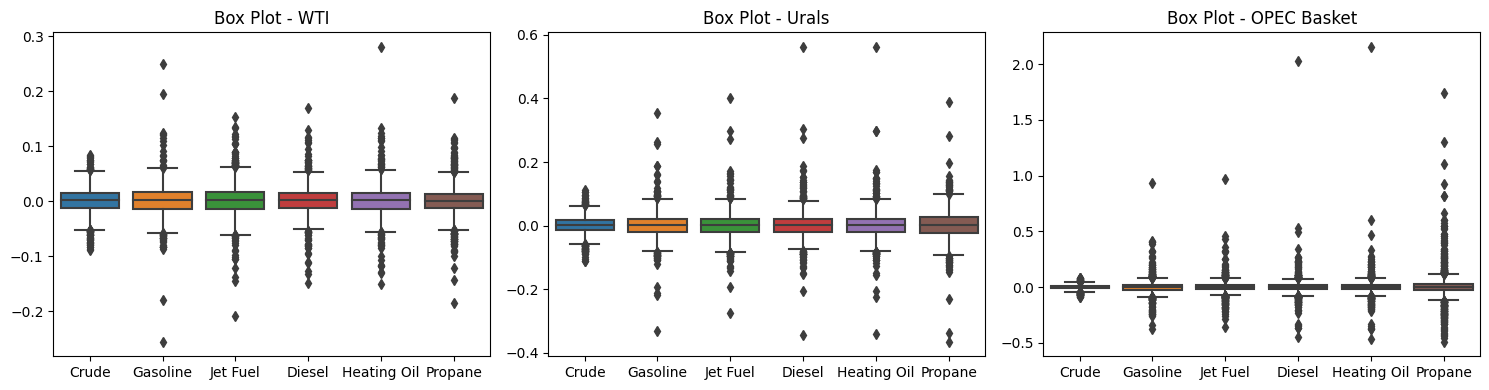

In [17]:
box_plots([wti_returns_df, urals_returns_df, opec_returns_df])

### Quantile-quantile Plot

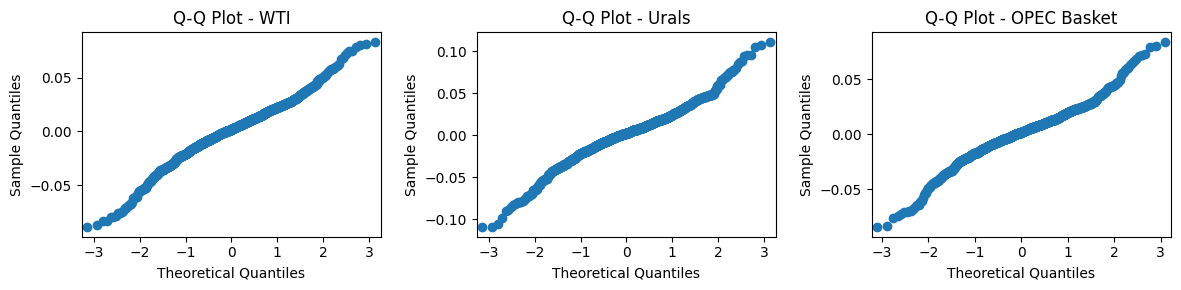

In [18]:
qqplot([wti_returns_df, urals_returns_df, opec_returns_df])

After removing outliers points on the QQ plots closely follow a straight line, indicating a reasonably good fit to a normal distribution. This suggests that the distribution of returns for WTI Crude oil prices is approximately normal.

### Correlation Matrix

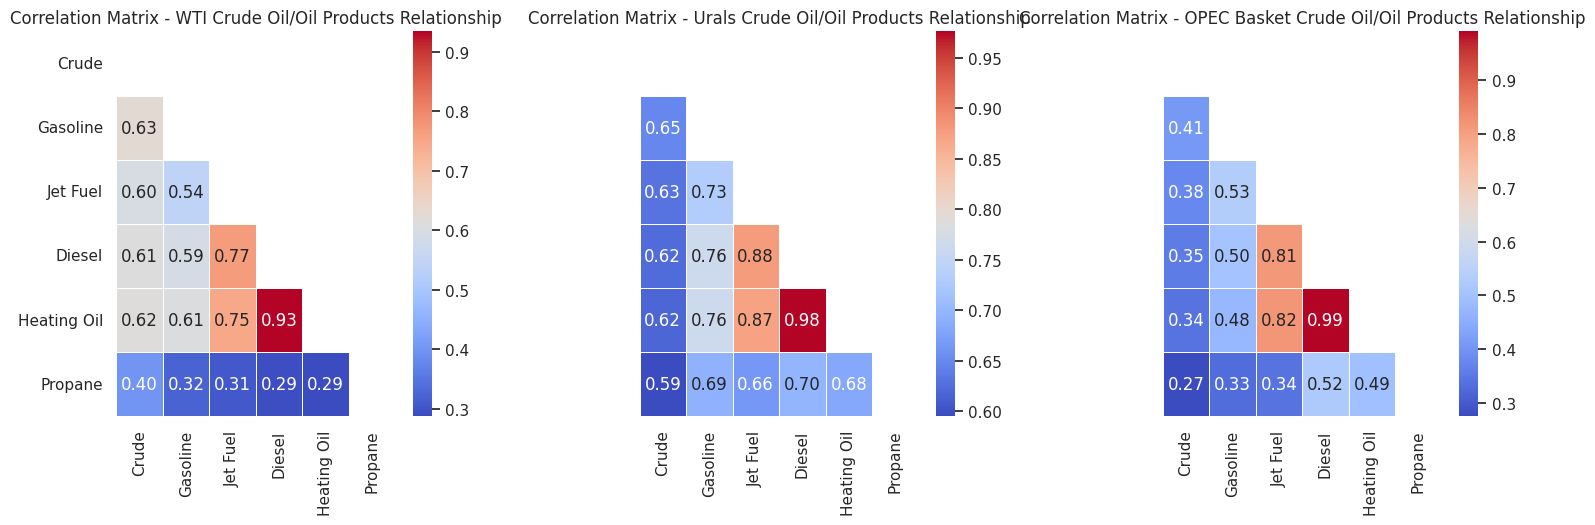

In [19]:
plot_corr_matrix([wti_returns_df, urals_returns_df, opec_returns_df])

Correlation matrix heatmaps show that Urals has the highest correlation between Crude oil and oil products from 0.75 for Propane to 0.79 for Gasoline. Heating oil and Diesel have almost perfect positive correlation. Crude, Gasoline, Jet Fuel, Diesel, and Heating Oil all show relatively weak correlations with Propane (ranging from 0.29 to 0.4) in the US and Middle East. This suggests a lower level of association between Propane prices and the other oil products. At the same time Russian oil products have higher correlation with Propane prices. Also we observed that Diesel and Heating Oil correlate well with Jet Fuel across all 3 regions.

### Distribution of returns and scatterplots showing relationships between returns of various oil products

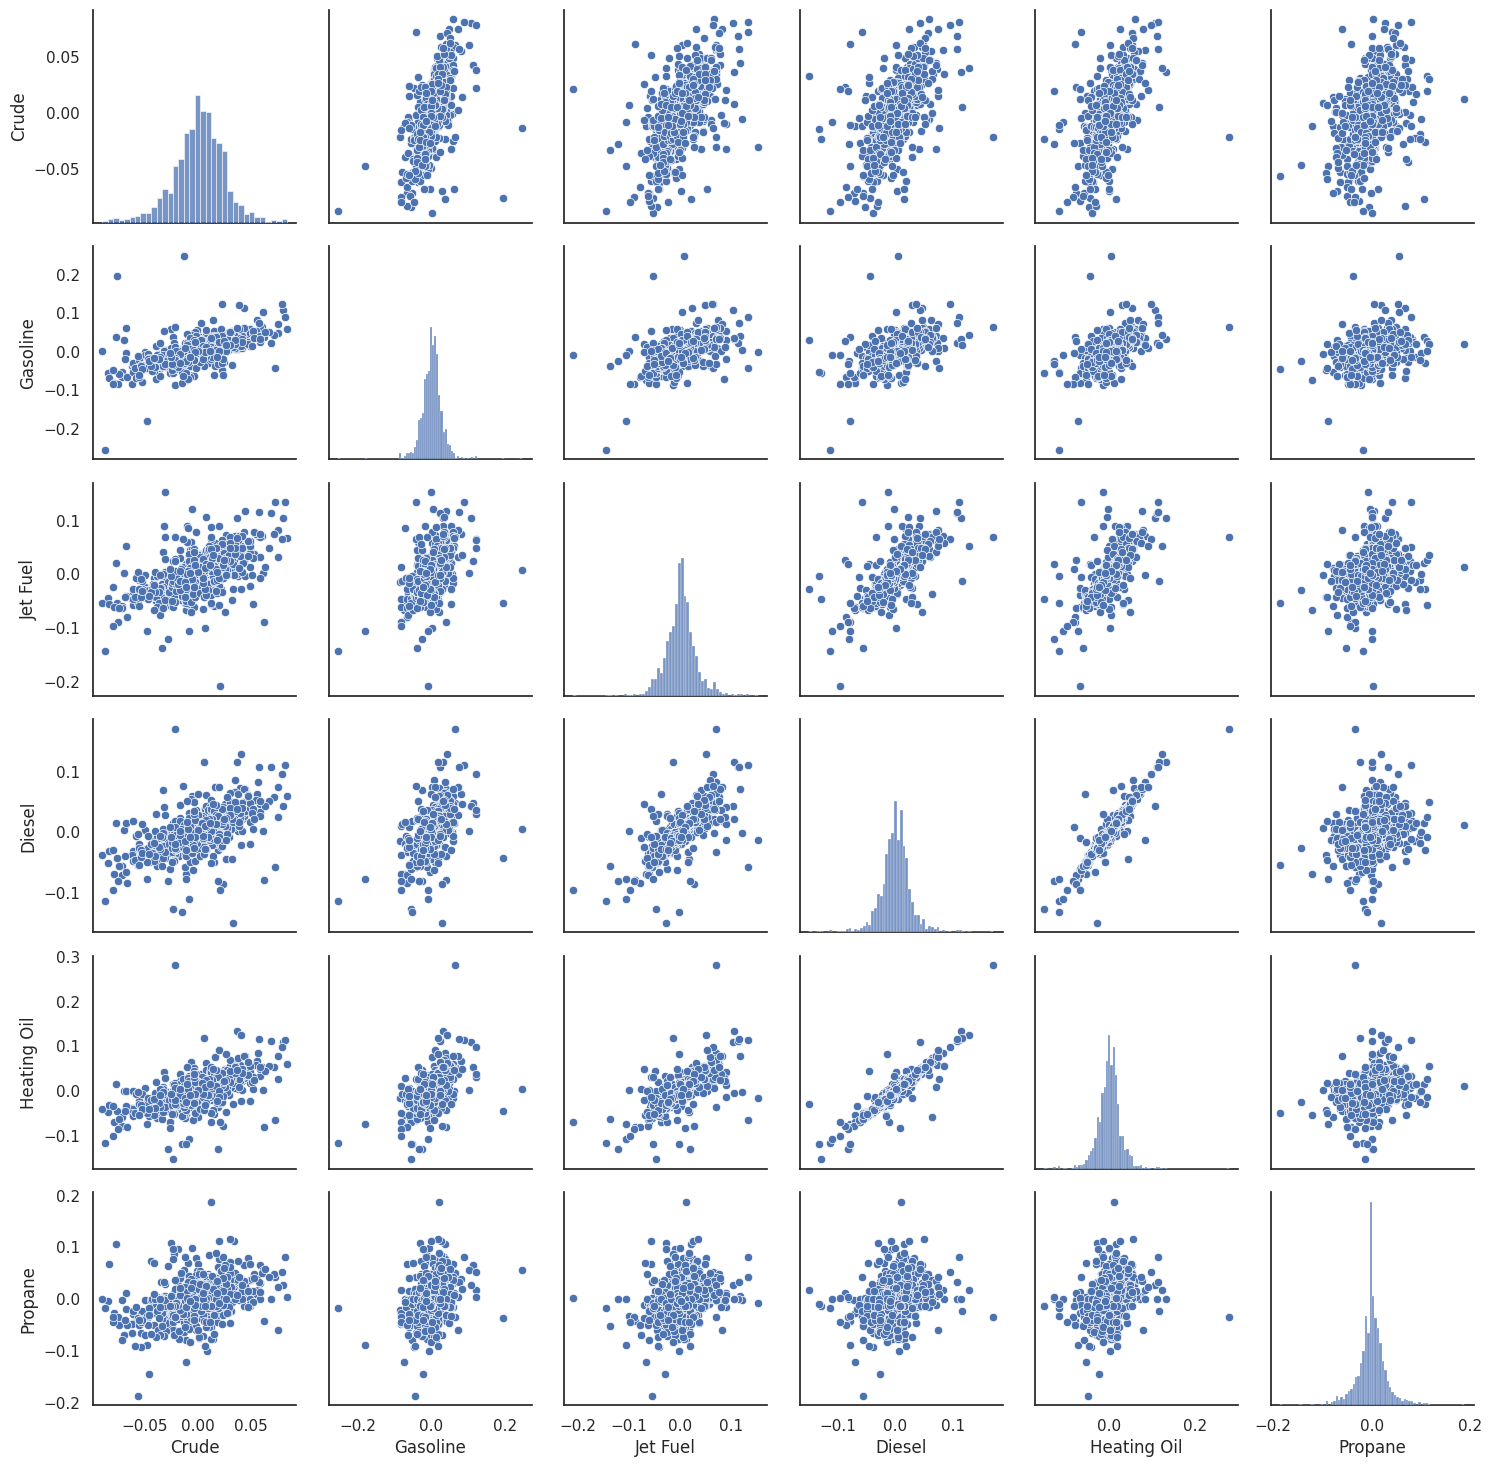

In [20]:
g = sns.PairGrid(wti_returns_df)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

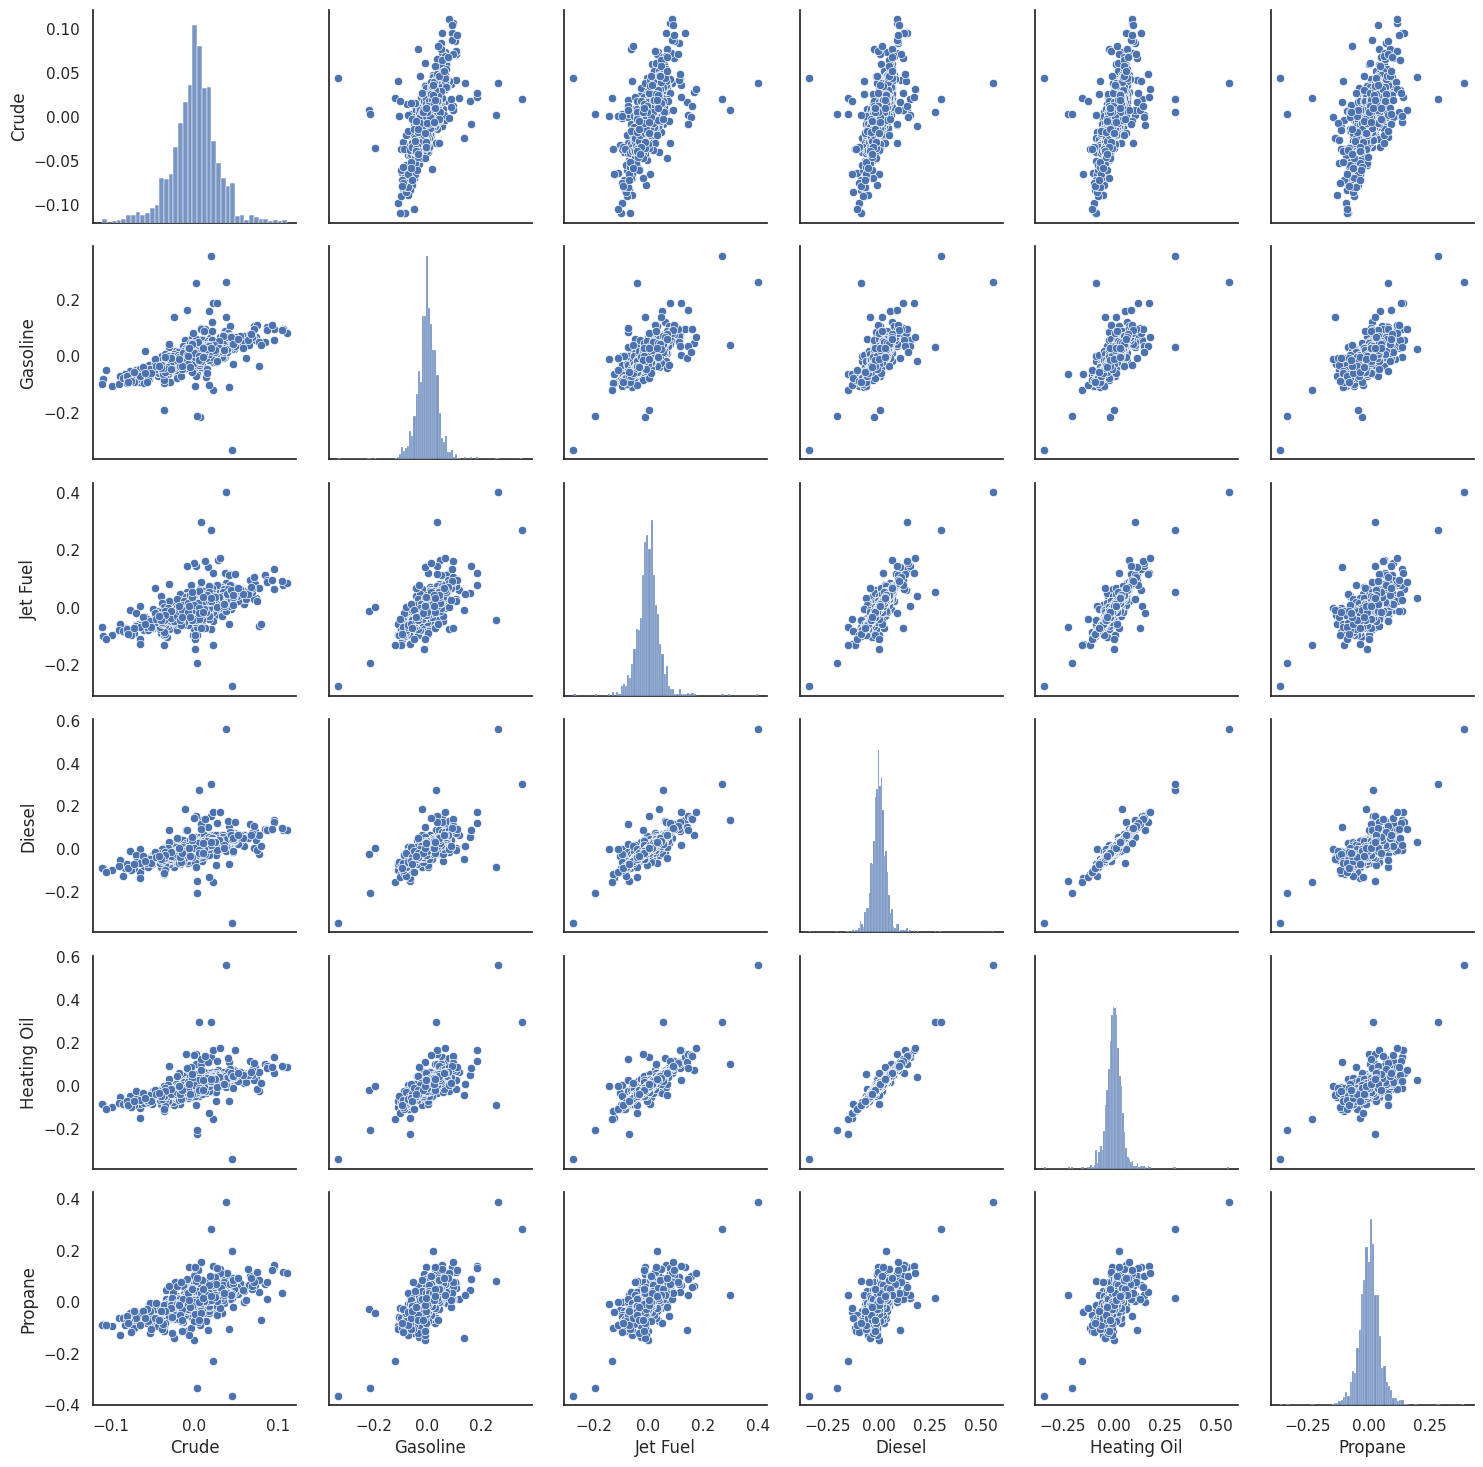

In [21]:
g = sns.PairGrid(urals_returns_df)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

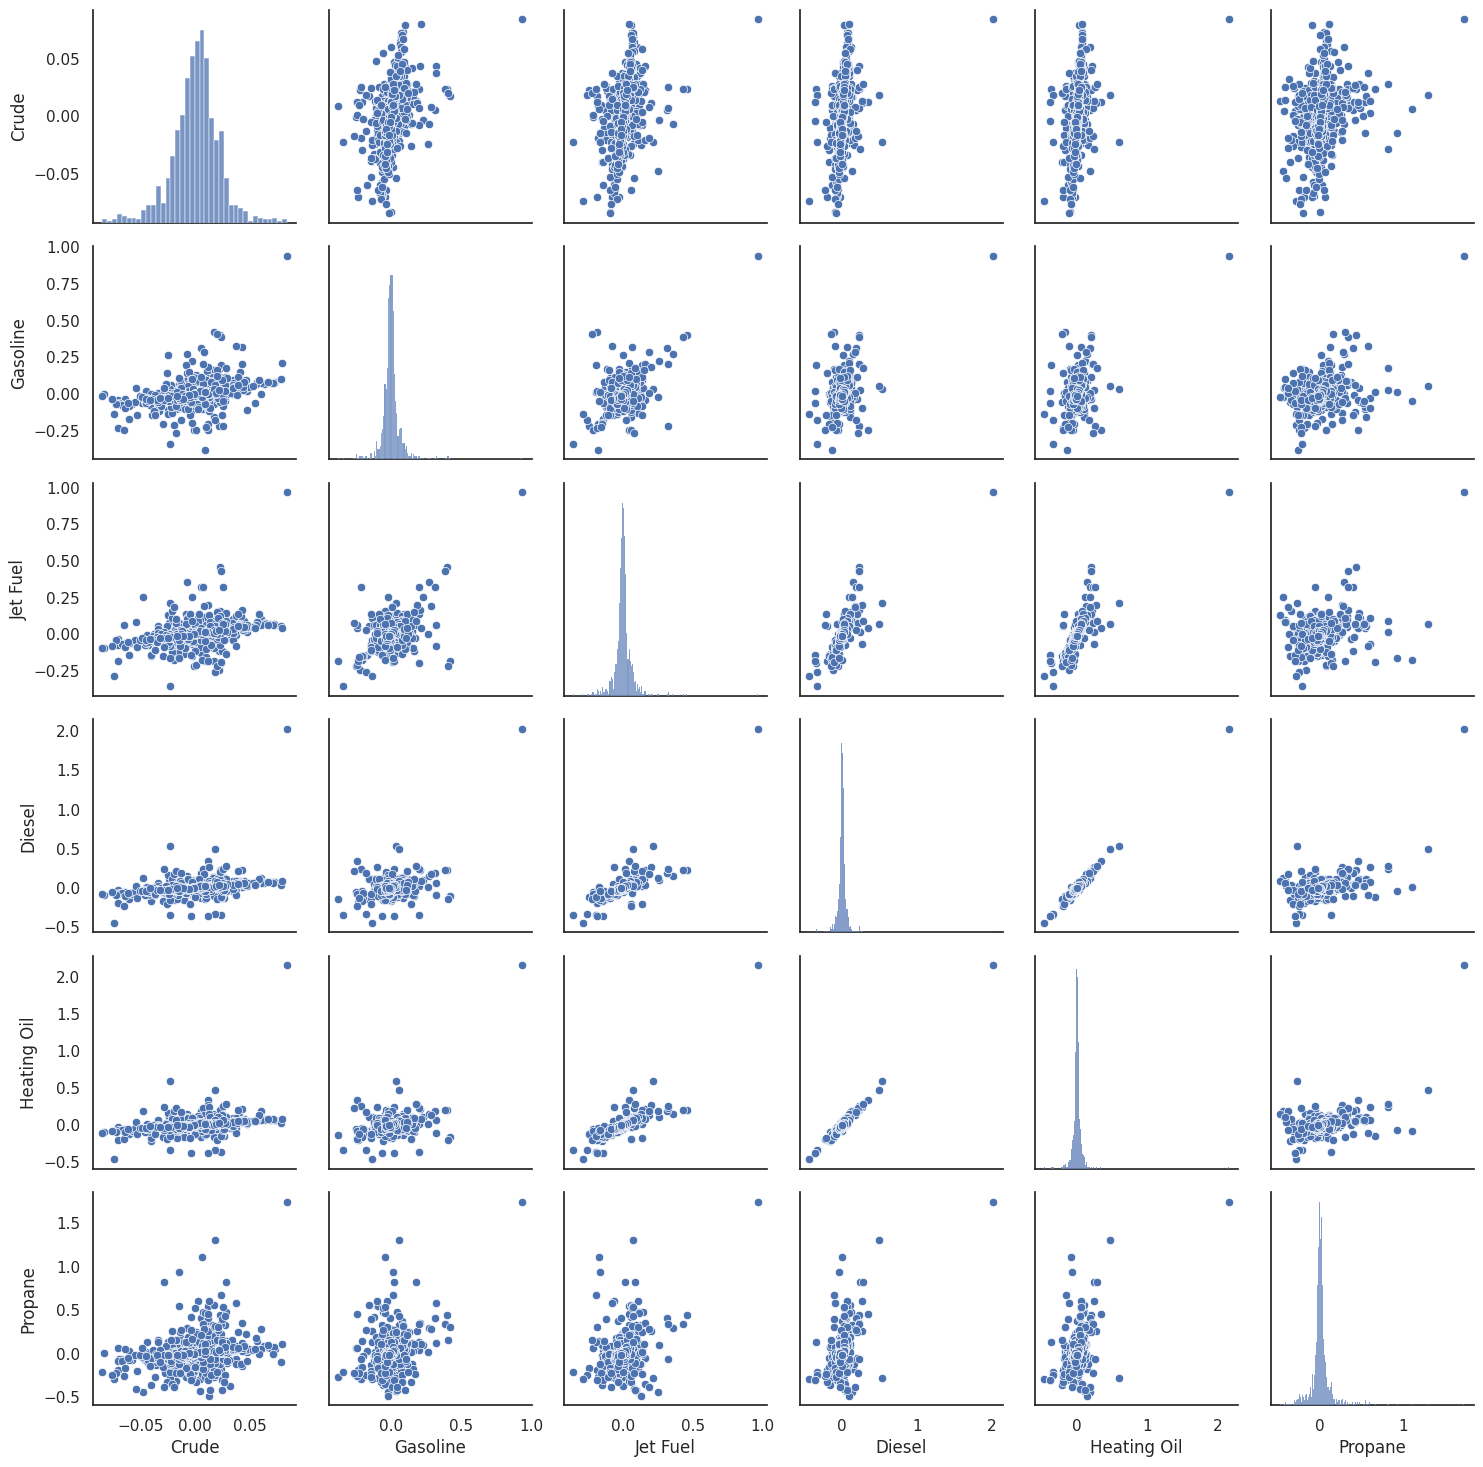

In [22]:
g = sns.PairGrid(opec_returns_df)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

### Key statistical metrics

In [23]:
statistics([wti_returns_df, urals_returns_df, opec_returns_df])

,Crude,Gasoline,Jet Fuel,Diesel,Heating Oil,Propane
Mean,0.000872,0.001573,0.001401,0.001106,0.001160,0.000243
Median,0.001886,0.002115,0.001670,0.001177,0.001531,0.000000
Variance,0.000590,0.000836,0.000963,0.000721,0.000836,0.000840
Skewness,-0.307867,0.101758,-0.031389,0.001643,0.596732,0.015399
Kurtosis,1.292120,13.098159,4.300616,5.156010,10.340653,4.872977
,Crude,Gasoline,Jet Fuel,Diesel,Heating Oil,Propane
Mean,0.001063,0.001491,0.001316,0.001726,0.001734,0.002148
Median,0.002204,0.001550,0.001195,0.001164,0.001428,0.003373
Variance,0.000773,0.001747,0.001829,0.001957,0.001992,0.002206
Skewness,-0.184712,0.381811,0.998583,1.855206,1.752958,-0.079943


Key statistical metrics such as variance, skewness, and kurtosis provide valuable insights into the distribution and behavior of oil products data, which is helpful for risk assessment. From the oil grades presented in our paper the Urals has the higher variance of price returns 0.000786. High variance indicates greater volatility, meaning that Urals prices were more volatile than WTI and OPEC basket over the last 4 years. Political event might have a significant impact on Urals prices.
Skewness helps assess the probability and potential impact of extreme events(e.g., wars and pandemics). All 3 blends have a slight positive skewness suggesting that the distribution of oil price returns is somewhat skewed to the right. This implies that dataset has higher-than-average returns outliers.
Crude price returns also have positive kurtosis, suggesting the presence of heavier tails.

### Covariance

In [24]:
calc_covariance([wti_returns_df, urals_returns_df, opec_returns_df])

,Crude,Gasoline,Jet Fuel,Diesel,Heating Oil,Propane
Crude,0.000590,0.000441,0.000450,0.000399,0.000432,0.000282
Gasoline,0.000441,0.000836,0.000489,0.000460,0.000508,0.000270
Jet Fuel,0.000450,0.000489,0.000963,0.000640,0.000672,0.000276
Diesel,0.000399,0.000460,0.000640,0.000721,0.000725,0.000228
Heating Oil,0.000432,0.000508,0.000672,0.000725,0.000836,0.000241
Propane,0.000282,0.000270,0.000276,0.000228,0.000241,0.000840
,Crude,Gasoline,Jet Fuel,Diesel,Heating Oil,Propane
Crude,0.000773,0.000752,0.000749,0.000765,0.000766,0.000777
Gasoline,0.000752,0.001747,0.001308,0.001413,0.001424,0.001359
Jet Fuel,0.000749,0.001308,0.001829,0.001663,0.001667,0.001336


Covariance is a measure of how much two random variables change together. The diagonal elements represent the variance of each individual variable. For example, the variance of WTI Crude Oil price returns is approximately 0.000590, and the variance of Gasoline is approximately 0.000836. The off-diagonal elements represent the covariance between pairs of variables. A positive covariance indicates that the variables tend to move in the same direction, while a negative covariance indicates that they move in opposite directions. The covariance between Crude Oil and Gasoline is approximately 0.000441. This positive covariance suggests that these two variables tend to move together. However, the strength of this relationship is better assessed when considering the standard deviations and correlation.

## Principal Component Analysis

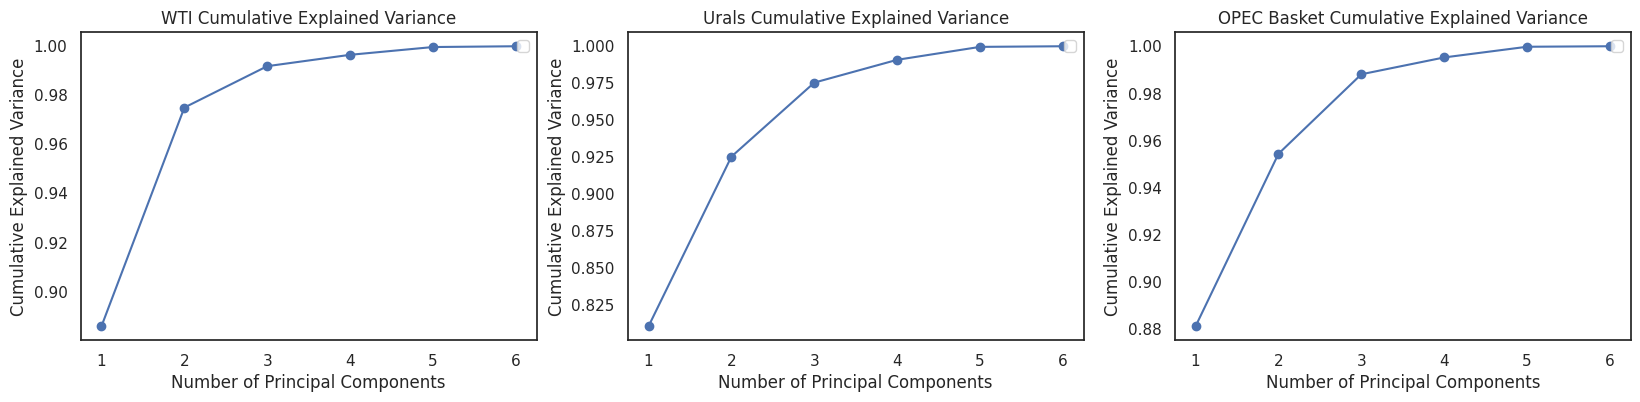

In [25]:
perform_pca([wti_df, urals_df, opec_df])

Principal Component Analysis (PCA) is a dimensionality reduction technique that transforms the original variables into a new set of uncorrelated variables called principal components. These components are linear combinations of the original variables and are ordered by the amount of variance they explain. PCA is useful for simplifying complex datasets, identifying patterns, and reducing the number of variables while retaining the most important information.
Scree plot above helped us to decide on the number of components. After examinig the plot of the cumulative explained variance against the number of components. The "elbow" is a point where the slope of the curve starts to flatten out. This is often considered a good point to stop adding components. In case of WTI 2 components capture a high percentage of the total variance. While Urals and OPEC basket 3 components explain.

## ARIMA model

### Stationarity Test

In [26]:
adf_test([wti_returns_df, urals_returns_df, opec_returns_df])

,Crude,Gasoline,Jet Fuel,Diesel,Heating Oil,Propane
ADF Statistic,-33.29307,-6.915682e+00,-20.493341,-32.928471,-33.618985,-1.791982e+01
p-value,0.00000,1.181169e-09,0.000000,0.000000,0.000000,2.908928e-30
,Crude,Gasoline,Jet Fuel,Diesel,Heating Oil,Propane
ADF Statistic,-1.521218e+01,-8.671134e+00,-7.948645e+00,-7.359160e+00,-7.505951e+00,-1.586722e+01
p-value,5.634538e-28,4.543183e-14,3.169502e-12,9.601835e-11,4.134384e-11,9.068418e-29
,Crude,Gasoline,Jet Fuel,Diesel,Heating Oil,Propane
ADF Statistic,-23.445711,-1.591977e+01,-1.088814e+01,-6.347293e+00,-6.352353e+00,-7.537854e+00
p-value,0.000000,7.948273e-29,1.244793e-19,2.663546e-08,2.592228e-08,3.440244e-11


Results of the tests show our data is stationary since p-values are extremely low.

### Autocorrelations and parameters

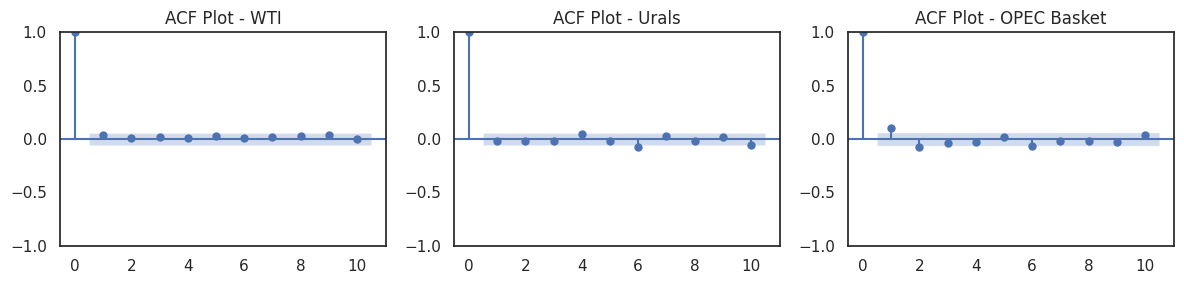

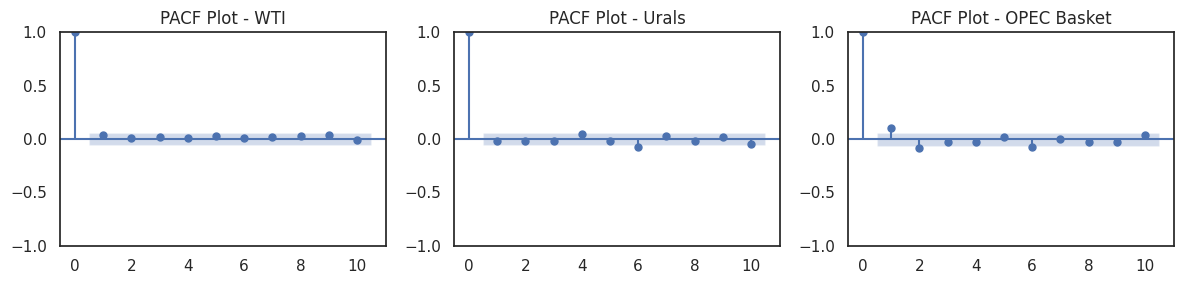

In [27]:
ac_plot([wti_returns_df, urals_returns_df, opec_returns_df])

ACF and PACF plots indicate that multiple autocorrelations are significantly non-zero. By analyzing the spikes on the graph we chose parameters for our models. As a result orders p=1 and q=1 were selected for ARIMA model since there are significant spikes at lags 1 on both plots. We have already applied differencing to crude oil data before fitting the model, therefore d parameter is zero. It's an AutoRegressive Integrated Moving Average model with a first-order autoregressive term, no differencing, and a first-order moving average term.

In [28]:
(wti_train_df, wti_validation_df, wti_test_df), (urals_train_df, urals_validation_df, urals_test_df), (opec_train_df, opec_validation_df, opec_test_df) = split_data([wti_df, urals_df, opec_df])

Data splitting is a fundamental practice in machine learning that helps in training, evaluating, and optimizing models to ensure they perform well on new and unseen data. We split our datasets using 80/10/10 ratio

###Results

In [29]:
summarize_arima([wti_returns_df, urals_returns_df, opec_returns_df])

Let's first interpret the resulting coeficients of the model. The p-value 0.261 indicates the statistical significance of the constant. A p-value greater than the significance level commonly 0.05 suggests that the constant is not statistically different from zero. In this case, the p-value is high 0.261, indicating that the constant is not statistically significant. The autoregressive term captures the relationship between the current value of the dependent variable and its previous value. The p-value 0.117 is also above 0.05 and thus statistically insignificant. The moving average term shows how previous forecast errors affect the current value of the dependent variable. The p-value 0.019 is less than 0.05, suggesting that the moving average term is statistically significant. We can conclude, the constant and autoregressive lag 1 term may not be statistically significant, while the moving average lag 1 term appears to be significant.

To ensure a good fit of the model we assessed log likelihood, AIC, and BIC. The AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion) are both statistical measures used for model selection. The AIC and BIC values provided in our output (-1149.564 for AIC and -1129.154 for BIC) are both negative. Lower AIC and BIC values, in this case, suggest that the ARIMA(1, 0, 1) model is relatively better among the considered models in terms of goodness of fit and complexity.

The log-likelihood is a measure of how well a statistical model explains the observed data. A higher log-likelihood indicates a better fit of the model to the data. The log-likelihood value of 578.782 suggests that the model is providing a reasonable fit to the observed data.


## GARCH model

In [30]:
def run_GARCH(dfs):
  num_plots = len(dfs)
  fig, axes = plt.subplots(nrows=1, ncols=num_plots, figsize=(20, 4))
  for i, (df, grade) in enumerate(zip(dfs, grades)):
    train = df[: int(df.shape[0] * 0.80)]
    test = df[int(0.80* df.shape[0]):]
    # Define and fit the GARCH model
    model = arch_model(train['Crude'].pct_change().dropna(), vol='Garch', mean = "Zero", p=1, q=1, rescale=False)
    results = model.fit(disp="off")

    # Display model summary
    print(results.summary())

    # Forecast volatility for the test data
    n_periods = len(test)
    forecast = results.forecast(horizon=n_periods)

    # Plot the forecasted volatility
    axes[i].plot(test.index, test['Crude'].pct_change(), label='Returns')
    axes[i].plot(test.index, forecast.variance.values[-1, :], label='Forecasted Volatility')
    axes[i].set_title(grade + ' GARCH Model Forecasted Volatility')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Volatility')
    axes[i].legend()
  plt.show()

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


                       Zero Mean - GARCH Model Results                        
Dep. Variable:                  Crude   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:                1574.28
Distribution:                  Normal   AIC:                          -3142.57
Method:            Maximum Likelihood   BIC:                          -3127.93
                                        No. Observations:                  972
Date:                Mon, Jan 15 2024   Df Residuals:                      972
Time:                        00:16:57   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.9102e-04  3.411e-05      5.601  2.135e-08 [1.

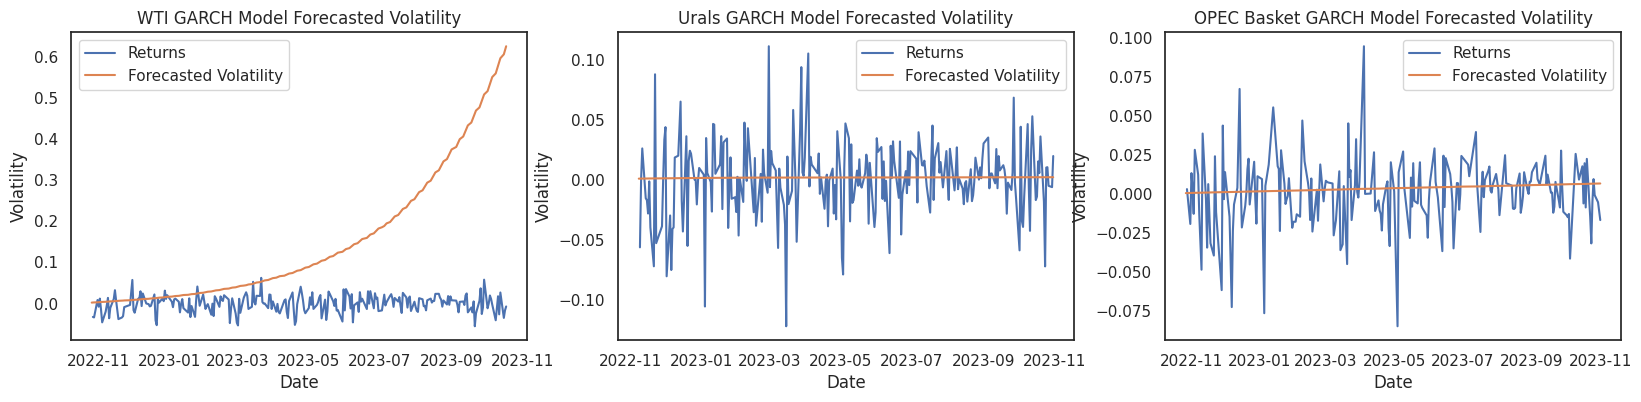

In [31]:
run_GARCH([wti_df, urals_df, opec_df])

The GARCH model is commonly used in financial econometrics to model the volatility of financial time series data. The omega parameter represents the baseline level of volatility. The positive value suggests there's a consistent, non-zero level of volatility. All three datasets have low p-value for omega meaning it's statistically significant and is not random.
The alpha parameter reflects how much recent changes in prices affect current volatility. A higher alpha means recent price changes strongly impact the current volatility. The positive and statistically significant value indicates the importance of recent price movements in predicting future volatility.

## Bayesian Neural Network

In [32]:
def run_BNN(dfs):

  num_samples=200
  num_warmup=100
  num_chains=1
  num_hidden=5

  num_plots = len(dfs)
  fig, axes = plt.subplots(nrows=1, ncols=num_plots, figsize=(20, 4))
  metrics_df = pd.DataFrame(index=['Mean Squared Error (MSE)', 'Mean Absolute Error (MAE)', 'Root Mean Squared Error (RMSE)'])

  for i, (df, grade) in enumerate(zip(dfs, grades)):
    def model(X, Y, D_H, D_Y=1):
      N, D_X = X.shape

      # Sample first layer (we put unit normal priors on all weights)
      w1 = numpyro.sample("w1", dist.Normal(jnp.zeros((D_X, D_H)), jnp.ones((D_X, D_H))))
      assert w1.shape == (D_X, D_H)
      z1 = jnp.tanh(jnp.matmul(X, w1))
      assert z1.shape == (N, D_H)

      # Sample second layer
      w2 = numpyro.sample("w2", dist.Normal(jnp.zeros((D_H, D_H)), jnp.ones((D_H, D_H))))
      assert w2.shape == (D_H, D_H)
      z2 = jnp.tanh(jnp.matmul(z1, w2))
      assert z2.shape == (N, D_H)

      # Sample final layer of weights and neural network output
      w3 = numpyro.sample("w3", dist.Normal(jnp.zeros((D_H, D_Y)), jnp.ones((D_H, D_Y))))
      assert w3.shape == (D_H, D_Y)
      z3 = jnp.matmul(z2, w3)
      assert z3.shape == (N, D_Y)

      if Y is not None:
          assert z3.shape == Y.shape

      # Set prior on the observation noise
      prec_obs = numpyro.sample("prec_obs", dist.Gamma(3.0, 1.0))
      sigma_obs = 1.0 / jnp.sqrt(prec_obs)

      # Observe data
      with numpyro.plate("data", N):
        numpyro.sample("Y", dist.Normal(z3, sigma_obs).to_event(1), obs=Y)


    # HMC inference
    def run_inference(model, num_warmup, num_samples, num_chains, rng_key, X, Y, D_H):
      start = time.time()
      kernel = NUTS(model)
      mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains, progress_bar=False, )
      mcmc.run(rng_key, X, Y, D_H)
      mcmc.print_summary()
      print("\nMCMC elapsed time:", time.time() - start)
      return mcmc.get_samples()


    # Prediction
    def predict(model, rng_key, samples, X, D_H):
      model = handlers.substitute(handlers.seed(model, rng_key), samples)
      model_trace = handlers.trace(model).get_trace(X=X, Y=None, D_H=D_H)
      return model_trace["Y"]["value"]

    num_data=len(df)

    train_size = int(len(df) * 0.8)
    train_data, test_data = df[:train_size], df[train_size:]

    X_train = train_data.drop('Crude', axis=1).values
    y_train = train_data[['Crude']].values

    X_test = test_data.drop('Crude', axis=1).values
    y_test = test_data[['Crude']].values

    # Do inference
    rng_key, rng_key_predict = random.split(random.PRNGKey(0))
    samples = run_inference(model, num_warmup, num_samples, num_chains, rng_key, X_train, y_train, num_hidden)

    # Predict Y_test at inputs X_test
    vmap_args = (
        samples,
        random.split(rng_key_predict, num_samples * num_chains),
    )
    predictions = vmap(
        lambda samples, rng_key: predict(model, rng_key, samples, X_test, num_hidden)
    )(*vmap_args)
    predictions = predictions[..., 0]

    # Compute predictions mean
    mean_prediction = jnp.mean(predictions, axis=0)

    # Plot the results
    axes[i].plot(test_data.index, y_test, label='Test Data')
    axes[i].plot(test_data.index, mean_prediction, label='Predictions', linestyle='dashed')
    axes[i].set_title(grade + ' Oil Price')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Price, USD')
    axes[i].legend()

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, mean_prediction)
    mae = mean_absolute_error(y_test, mean_prediction)
    rmse = np.sqrt(mse)

    metrics_df[grade] = [mse, mae, rmse]

  return fig, metrics_df
  # print(metrics_df)

In [33]:
%%capture
plots, metrics = run_BNN([wti_df, urals_df, opec_df])

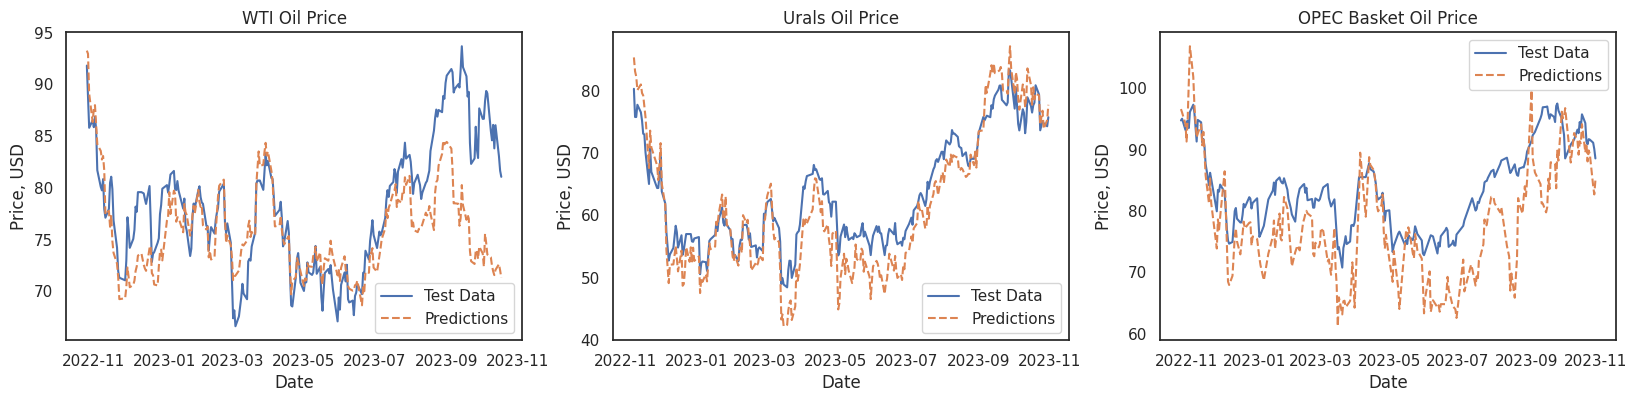

                                      WTI      Urals  OPEC Basket
Mean Squared Error (MSE)        27.035625  16.702851    58.796365
Mean Absolute Error (MAE)        3.635369   3.554353     6.411755
Root Mean Squared Error (RMSE)   5.199579   4.086912     7.667879


In [34]:
display(plots)
print(metrics)

## LSTM Neural Network

In [35]:
def run_LSTM(dfs):
  num_plots = len(dfs)
  fig, axes = plt.subplots(nrows=1, ncols=num_plots, figsize=(20, 4))

  # LSTM model parameters
  seq_length = 10
  model = Sequential()
  model.add(LSTM(50, activation='relu', input_shape=(seq_length, 1)))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')

  metrics_df = pd.DataFrame(index=['Test Loss', 'Mean Squared Error (MSE)', 'Mean Absolute Error (MAE)', 'Root Mean Squared Error (RMSE)'])

  for i, (df, grade) in enumerate(zip(dfs, grades)):

    train_size = int(len(df) * 0.8)
    scaler = MinMaxScaler(feature_range=(0, 1))
    df_scaled = scaler.fit_transform(df[['Crude']])

    train_data, test_data = df_scaled[:train_size], df_scaled[train_size:]

    def create_sequences(data, seq_length):
      sequences, labels = [], []
      for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length:i+seq_length+1][0]
        sequences.append(seq)
        labels.append(label)

      return np.array(sequences), np.array(labels)

    X_train, y_train = create_sequences(train_data, seq_length)
    X_test, y_test = create_sequences(test_data, seq_length)

    # Train the model
    model.fit(X_train, y_train, epochs=30, verbose=0)

    # Evaluate the model on the test data
    test_loss = model.evaluate(X_test, y_test, verbose=0)

    # Make predictions
    predictions = model.predict(X_test, verbose=0)
    predictions = scaler.inverse_transform(predictions)

    # Plot the results
    period = train_size+seq_length
    y_test = df['Crude'][period:]
    df_index = df.index[period:]

    axes[i].plot(df_index, y_test, label='Test Data')
    axes[i].plot(df_index, predictions, label='Test Predictions', linestyle='dashed')
    axes[i].set_title(grade + ' Oil Price')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Price, USD')
    axes[i].legend()

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mse)

    metrics_df[grade] = [test_loss, mse, mae, rmse]

  plt.show()
  print(metrics_df)

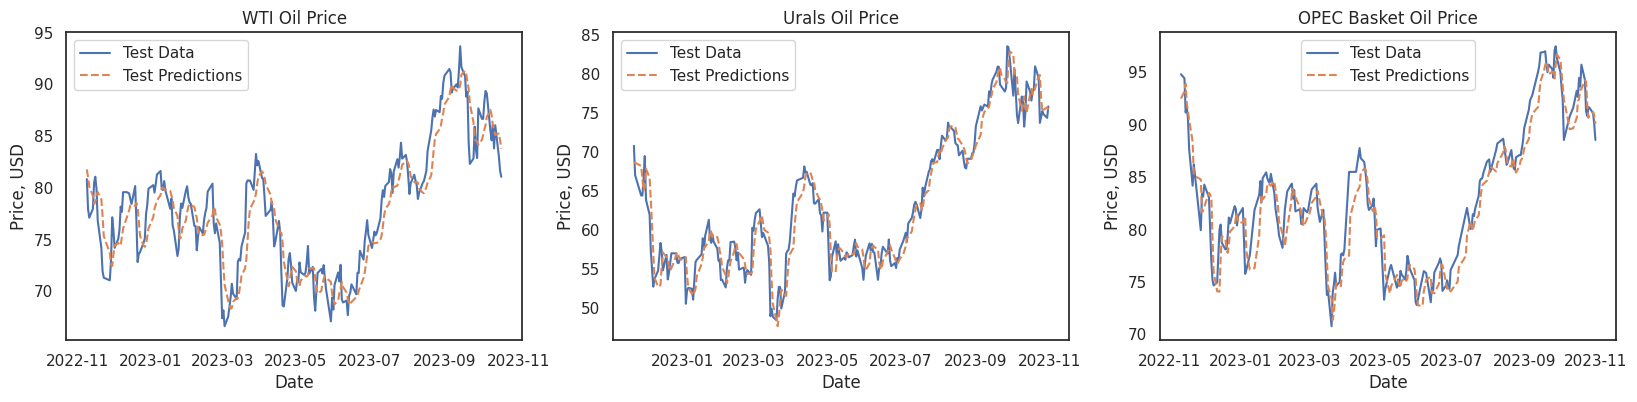

                                     WTI     Urals  OPEC Basket
Test Loss                       0.000230  0.000492     0.000316
Mean Squared Error (MSE)        5.932119  5.178764     4.214113
Mean Absolute Error (MAE)       1.999318  1.720601     1.592955
Root Mean Squared Error (RMSE)  2.435594  2.275690     2.052831


In [36]:
run_LSTM([wti_df, urals_df, opec_df])

The LSTM outperforms the Bayesian Neural Network in all three evaluation metrics. Lower MSE, MAE, and RMSE values for the LSTM indicate that it provides more accurate and precise predictions for crude oil prices compared to the BNN.
Based on these evaluation metrics, the LSTM model appears to be a more effective choice for forecasting crude oil prices than the Bayesian Neural Network.